<a href="https://colab.research.google.com/github/Samjacob007/image-segmentation/blob/main/Image_segmentation_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Importing relevant modules.

import random
import numpy as np
import matplotlib.pyplot as plt
from pycocotools.coco import COCO  # API for COCO dataset.
import skimage.io as io

%matplotlib inline

In [ ]:
# Import and mount Google Drive.

from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
# Unzip the dataset file and store it in a folder called images.

!unzip -o "/content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip" -d "/content/drive/MyDrive/coco2017/"

Archive:  /content/drive/MyDrive/RM_Segmentation_Assignment_dataset.zip
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001751.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001380.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001643.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001583.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001685.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001482.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001494.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001551.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001654.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001594.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001411.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/000000001459.jpg  
  inflating: /content/drive/MyDrive/coco2017/test-30/00000000141

In [ ]:
# Define location of training data (images and labels).

train_data_path = "/content/drive/MyDrive/coco2017/train-300"
train_annotation_file = f"{train_data_path}/labels.json"

In [ ]:
# Initialising COCO API for instance annotations.

coco = COCO(train_annotation_file)

loading annotations into memory...
Done (t=0.10s)
creating index...
index created!


In [ ]:
# Extract and display COCO categories and supercategories for the training dataset.

category_IDs = coco.getCatIds()
categories = coco.loadCats(category_IDs)

print(categories)

names_cats = [cats["name"] for cats in categories]
print(len(names_cats), "COCO categories:", " ".join(names_cats))

names_scats = set([cats["supercategory"] for cats in categories])
print(len(names_scats), "COCO supercategories:", " ".join(names_scats))

[{'id': 0, 'name': 'airplane', 'supercategory': 'vehicle'}, {'id': 1, 'name': 'backpack', 'supercategory': 'accessory'}, {'id': 2, 'name': 'banana', 'supercategory': 'food'}, {'id': 3, 'name': 'baseball bat', 'supercategory': 'sports'}, {'id': 4, 'name': 'baseball glove', 'supercategory': 'sports'}, {'id': 5, 'name': 'bear', 'supercategory': 'animal'}, {'id': 6, 'name': 'bench', 'supercategory': 'outdoor'}, {'id': 7, 'name': 'bicycle', 'supercategory': 'vehicle'}, {'id': 8, 'name': 'bird', 'supercategory': 'animal'}, {'id': 9, 'name': 'boat', 'supercategory': 'vehicle'}, {'id': 10, 'name': 'book', 'supercategory': 'indoor'}, {'id': 11, 'name': 'bottle', 'supercategory': 'kitchen'}, {'id': 12, 'name': 'bowl', 'supercategory': 'kitchen'}, {'id': 13, 'name': 'broccoli', 'supercategory': 'food'}, {'id': 14, 'name': 'bus', 'supercategory': 'vehicle'}, {'id': 15, 'name': 'cake', 'supercategory': 'food'}, {'id': 16, 'name': 'car', 'supercategory': 'vehicle'}, {'id': 17, 'name': 'carrot', 'sup

In [ ]:
# Define function to extract category name from ID.

def get_category_name(class_ID, categories):
    for i in range(len(categories)):
        if categories[i]["id"] == class_ID:
            return categories[i]["name"]
    return "None"

In [ ]:
# Look at one example.

category_name_10 = get_category_name(10, categories)
print(f"The category name is {category_name_10}.")

# Make sure to check out some others.

The category name is book.


In [ ]:
# Get all training images containing a given object category or categories.
# Remember, for this assignment we will focus on the classes "person", "cake", "dog", "car"!

filter_class = ["cat"]
category_IDs = coco.getCatIds(catNms=filter_class)
image_IDs = coco.getImgIds(catIds=category_IDs)

print(f"Number of images containing specified category(ies): {len(image_IDs)}.")
print(f"IDs of images containing specified category(ies): {image_IDs}.")

# What happens when you are filtering for a different category or multiple classes?

Number of images containing specified category(ies): 4.
IDs of images containing specified category(ies): [299, 132, 268, 294].


{'id': 299, 'file_name': '000000003935.jpg', 'height': 554, 'width': 640, 'license': None, 'coco_url': None}


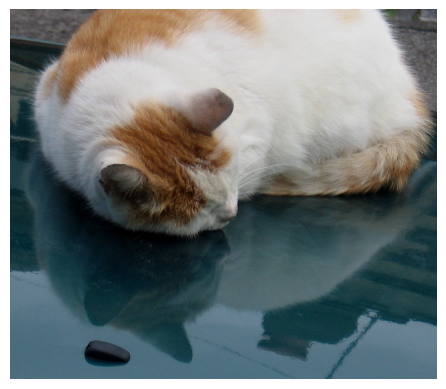

In [ ]:
# Load and display one of the example images.

example_image = coco.loadImgs(image_IDs[0])[0]
print(example_image)

image = io.imread(f'{train_data_path}/data/{example_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

plt.show()

In [ ]:
# Get COCO annotation IDs and content of annotations, i.e., bounding boxes and segmentation masks.

test_image_annotations_ID = coco.getAnnIds(
    imgIds=example_image["id"], catIds=category_IDs, iscrowd=None
)
print(test_image_annotations_ID)

test_image_annotations = coco.loadAnns(test_image_annotations_ID)
print(test_image_annotations)

# Make sure you understand the content of the annotations.

[3840]
[{'id': 3840, 'image_id': 299, 'category_id': 18, 'bbox': [33.36, 0.83, 602.85, 338.35], 'segmentation': [[266.0, 338.5, 225.0, 337.5, 158.0, 319.5, 156.0, 313.5, 139.0, 308.5, 121.0, 296.5, 111.0, 276.5, 66.5, 247.0, 51.5, 220.0, 47.5, 182.0, 32.5, 148.0, 44.5, 96.0, 67.0, 75.5, 72.5, 87.0, 88.5, 43.0, 139.0, 0, 554.0, 1.5, 601.5, 116.0, 635.5, 163.0, 611.5, 217.0, 589.5, 250.0, 554.0, 264.5, 466.0, 277.5, 346.0, 280.5, 335.5, 284.0, 346.0, 303.5, 331.0, 309.5, 316.0, 324.5, 287.0, 328.5, 266.0, 338.5]], 'area': 203974.29750000002, 'iscrowd': 0, 'supercategory': 'animal'}]


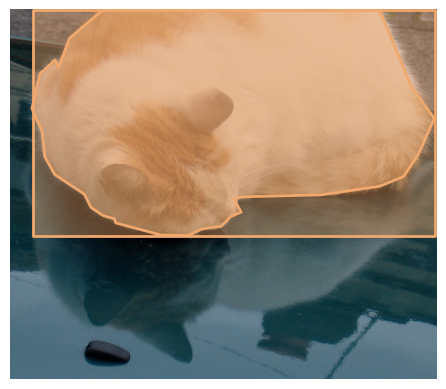

In [ ]:
# Load and display test image with instance annotations.

plt.imshow(image)
plt.axis("off")

coco.showAnns(test_image_annotations, draw_bbox=True)

# Try to remove the bounding box from the image and show the segmentation ground truth only.

In [ ]:
# Extract the training images that contain any combination of the four target classes.

target_classes = ["cake", "car", "dog", "person"]
target_classes_IDs = coco.getCatIds(catNms=target_classes)
training_images = []

# Iterate over each individual class in the list.
for class_name in target_classes:
    # Get all images containing target class.
    print(class_name)
    training_images_categories = coco.getCatIds(catNms=class_name)
    training_images_IDs = coco.getImgIds(catIds=training_images_categories)
    training_images += coco.loadImgs(training_images_IDs)

print(
    f"Number of images with target classes including repetitions: {len(training_images)}."
)

cake
car
dog
person
Number of images with target classes including repetitions: 566.


In [ ]:
# Filter out repeated images.

unique_training_images = []

for i in range(len(training_images)):
    if training_images[i] not in unique_training_images:
        unique_training_images.append(training_images[i])

# Shuffle the training data.
random.seed(0)
random.shuffle(unique_training_images)

print(
    f"Number of unique images in training data containing the target classes: {len(unique_training_images)}"
)


Number of unique images in training data containing the target classes: 300


{'id': 101, 'file_name': '000000007201.jpg', 'height': 427, 'width': 640, 'license': None, 'coco_url': None}


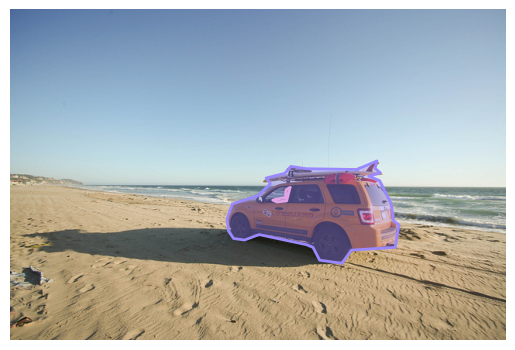

In [ ]:
# Load and display example training image with segmentation masks.

training_image = unique_training_images[10]
print(training_image)

image = io.imread(f'{train_data_path}/data/{training_image["file_name"]}')
plt.axis("off")
plt.imshow(image)

training_image_annotations_ID = coco.getAnnIds(
    imgIds=training_image["id"], catIds=target_classes_IDs, iscrowd=None
)
training_image_annotations = coco.loadAnns(training_image_annotations_ID)
coco.showAnns(training_image_annotations, draw_bbox=False)

plt.show()

In [ ]:
# To generate segmentation mask use annToMask function and extract the info stored in the annotations.
# For example, for the first object in our example training image:

mask_example = coco.annToMask(training_image_annotations[0])

print(type(mask_example))
print(mask_example)
print(mask_example.shape)
print(np.max(mask_example))
print(np.min(mask_example))

<class 'numpy.ndarray'>
[[0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]
(427, 640)
1
0


Unique pixel values in the mask: [0. 3.]


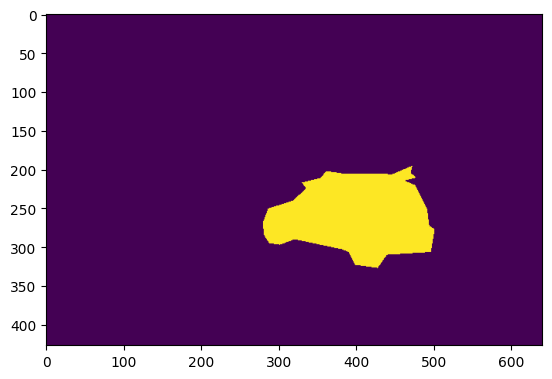

In [ ]:
# Plotting the segmentation masks with different colours.
# There are many ways to do this. This is just one example.

mask = np.zeros((training_image["height"], training_image["width"]))

for i in range(len(training_image_annotations)):
    # Get object category name.
    object_category = get_category_name(
        training_image_annotations[i]["category_id"], categories
    )
    # Assign pixel value based on location in target_classes list.
    pixel_value = target_classes.index(object_category) + 1
    # Assign pixel value to mask based on annToMask output.
    mask = np.maximum(coco.annToMask(training_image_annotations[i]) * 3, mask)

print(f"Unique pixel values in the mask: {np.unique(mask)}")

plt.imshow(mask)
plt.show()

In [ ]:
import os
import torch
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import numpy as np
from pycocotools.coco import COCO
import skimage.io as io

class COCOSegmentationDataset(Dataset):
    def __init__(self, image_dir, annotation_file, target_classes, image_size=(128, 128)):

        self.image_dir = image_dir
        self.coco = COCO(annotation_file)
        self.image_size = image_size
        self.target_classes = target_classes
        self.cat_ids = self.coco.getCatIds(catNms=target_classes)

        # Get unique image IDs containing any of the target classes
        image_ids = []
        for cat_id in self.cat_ids:
            image_ids += self.coco.getImgIds(catIds=cat_id)
        self.image_ids = list(set(image_ids))

        # Mapping category id to target index (1 to 4)
        self.class_map = {cat_id: idx + 1 for idx, cat_id in enumerate(self.cat_ids)}

        # Define image transforms
        self.image_transform = transforms.Compose([
            transforms.ToTensor(),  # Converts to [0,1] and CHW format
            transforms.Resize(self.image_size)
        ])

    def __len__(self):
        return len(self.image_ids)

    def __getitem__(self, idx):
        img_id = self.image_ids[idx]
        img_info = self.coco.loadImgs(img_id)[0]
        img_path = os.path.join(self.image_dir, img_info["file_name"])

        # Load and transform image
        image = Image.open(img_path).convert("RGB")
        image = self.image_transform(image)

        # Create blank mask
        mask = np.zeros((img_info["height"], img_info["width"]), dtype=np.uint8)

        # Load annotations for this image
        ann_ids = self.coco.getAnnIds(imgIds=img_id, catIds=self.cat_ids)
        anns = self.coco.loadAnns(ann_ids)

        for ann in anns:
            cat_id = ann["category_id"]
            if cat_id in self.class_map:
                class_idx = self.class_map[cat_id]
                ann_mask = self.coco.annToMask(ann)
                mask = np.where(ann_mask == 1, class_idx, mask)

        # Resize mask
        mask = Image.fromarray(mask)
        mask = mask.resize(self.image_size, resample=Image.NEAREST)
        mask = torch.from_numpy(np.array(mask)).long()  # (H, W) class indices

        return image, mask


loading annotations into memory...
Done (t=0.04s)
creating index...
index created!


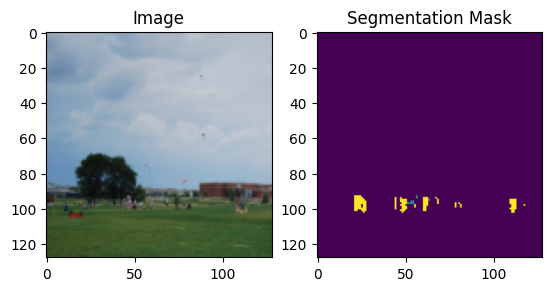

In [ ]:
# Define paths
image_dir = "/content/drive/MyDrive/coco2017/train-300/data"
annotation_file = "/content/drive/MyDrive/coco2017/train-300/labels.json"
target_classes = ["cake", "car", "dog", "person"]

# Create dataset
train_dataset = COCOSegmentationDataset(
    image_dir=image_dir,
    annotation_file=annotation_file,
    target_classes=target_classes,
    image_size=(128, 128)
)

# Example: show one image and mask
import matplotlib.pyplot as plt

img, mask = train_dataset[0]
plt.subplot(1, 2, 1)
plt.imshow(img.permute(1, 2, 0))  # Convert CHW to HWC
plt.title("Image")

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.title("Segmentation Mask")
plt.show()


In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=5):
        super(UNet, self).__init__()

        def conv_block(in_ch, out_ch):
            return nn.Sequential(
                nn.Conv2d(in_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True),
                nn.Conv2d(out_ch, out_ch, kernel_size=3, padding=1),
                nn.ReLU(inplace=True)
            )

        self.enc1 = conv_block(in_channels, 64)
        self.pool1 = nn.MaxPool2d(2)

        self.enc2 = conv_block(64, 128)
        self.pool2 = nn.MaxPool2d(2)

        self.enc3 = conv_block(128, 256)
        self.pool3 = nn.MaxPool2d(2)

        self.enc4 = conv_block(256, 512)
        self.pool4 = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.upconv4 = nn.ConvTranspose2d(1024, 512, 2, stride=2)
        self.dec4 = conv_block(1024, 512)

        self.upconv3 = nn.ConvTranspose2d(512, 256, 2, stride=2)
        self.dec3 = conv_block(512, 256)

        self.upconv2 = nn.ConvTranspose2d(256, 128, 2, stride=2)
        self.dec2 = conv_block(256, 128)

        self.upconv1 = nn.ConvTranspose2d(128, 64, 2, stride=2)
        self.dec1 = conv_block(128, 64)

        self.out_conv = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        # Encoder
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool1(e1))
        e3 = self.enc3(self.pool2(e2))
        e4 = self.enc4(self.pool3(e3))

        # Bottleneck
        b = self.bottleneck(self.pool4(e4))

        # Decoder
        d4 = self.upconv4(b)
        d4 = self.dec4(torch.cat([d4, e4], dim=1))

        d3 = self.upconv3(d4)
        d3 = self.dec3(torch.cat([d3, e3], dim=1))

        d2 = self.upconv2(d3)
        d2 = self.dec2(torch.cat([d2, e2], dim=1))

        d1 = self.upconv1(d2)
        d1 = self.dec1(torch.cat([d1, e1], dim=1))

        return self.out_conv(d1)


In [ ]:
import torch
torch.cuda.empty_cache()


In [ ]:
import torch.optim as optim

# Move model to device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = UNet(in_channels=3, out_channels=5).to(device)

weights = torch.tensor([0.2, 1.0, 0.5, 1.0, 1.0], device=device)
criterion = nn.CrossEntropyLoss(weight=weights)


optimizer = optim.Adam(model.parameters(), lr=1e-4)


In [ ]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True)



In [ ]:
num_epochs = 20

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, masks in train_loader:
        images = images.to(device)
        masks = masks.to(device)

        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, masks)

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        epoch_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")


Epoch [1/20], Loss: 157.0477
Epoch [2/20], Loss: 129.8208
Epoch [3/20], Loss: 127.4645
Epoch [4/20], Loss: 124.8565
Epoch [5/20], Loss: 124.1131
Epoch [6/20], Loss: 120.1124
Epoch [7/20], Loss: 118.1165
Epoch [8/20], Loss: 116.9657
Epoch [9/20], Loss: 113.1830
Epoch [10/20], Loss: 112.9480
Epoch [11/20], Loss: 110.4660
Epoch [12/20], Loss: 111.2454
Epoch [13/20], Loss: 108.4160
Epoch [14/20], Loss: 111.1581
Epoch [15/20], Loss: 111.7255
Epoch [16/20], Loss: 109.6452
Epoch [17/20], Loss: 109.7615
Epoch [18/20], Loss: 109.8033
Epoch [19/20], Loss: 109.5132
Epoch [20/20], Loss: 108.9155


In [ ]:
torch.save(model.state_dict(), "/content/drive/MyDrive/unet_coco_segmentation.pth")


In [ ]:
def pixel_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

def compute_iou(preds, labels, num_classes=5):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = (pred_inds & label_inds).sum().float()
        union = (pred_inds | label_inds).sum().float()
        if union == 0:
            ious.append(torch.tensor(float('nan')))
        else:
            ious.append(intersection / union)
    return ious


In [ ]:
pred = torch.argmax(outputs[0], dim=0).cpu().numpy()
print("Unique predicted class indices:", np.unique(pred))

Unique predicted class indices: [0 4]


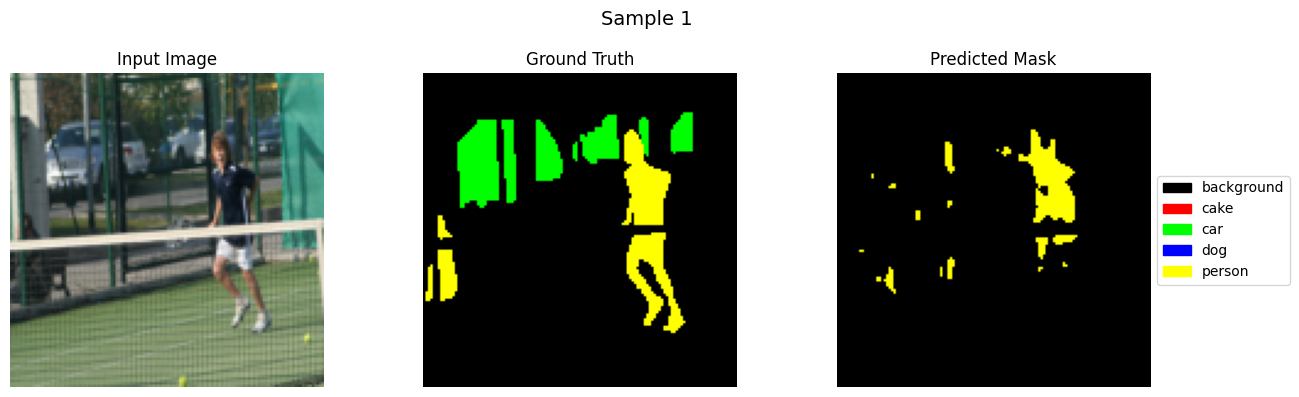

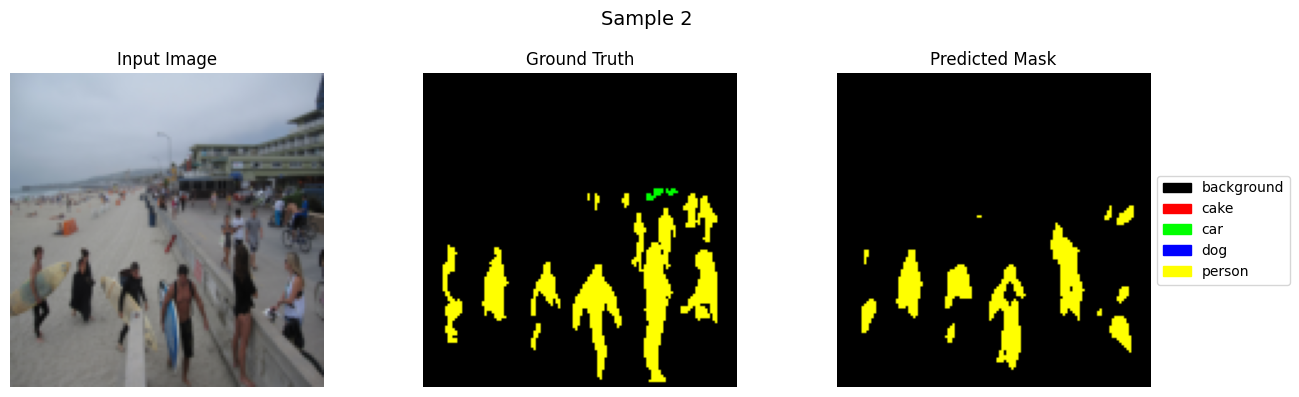

In [ ]:
import random
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import numpy as np
import torch

# Define class names and colors
class_names = ['background', 'cake', 'car', 'dog', 'person']
class_colors = {
    0: (0, 0, 0),        # Black for background
    1: (255, 0, 0),      # Red for cake
    2: (0, 255, 0),      # Green for car
    3: (0, 0, 255),      # Blue for dog
    4: (255, 255, 0)     # Yellow for person
}

def apply_color_mask(mask):
    """Apply RGB color to each class index in the mask"""
    color_mask = np.zeros((*mask.shape, 3), dtype=np.uint8)
    for class_idx, color in class_colors.items():
        color_mask[mask == class_idx] = color
    return color_mask

def visualize_prediction(image, mask, pred, index=0):
    image = image.cpu().permute(1, 2, 0).numpy()
    mask = mask.cpu().numpy()
    pred = torch.argmax(pred, dim=0).cpu().numpy()

    mask_color = apply_color_mask(mask)
    pred_color = apply_color_mask(pred)

    plt.figure(figsize=(14, 4))
    plt.suptitle(f"Sample {index+1}", fontsize=14)

    plt.subplot(1, 3, 1)
    plt.imshow(image)
    plt.title("Input Image")
    plt.axis("off")

    plt.subplot(1, 3, 2)
    plt.imshow(mask_color)
    plt.title("Ground Truth")
    plt.axis("off")

    plt.subplot(1, 3, 3)
    plt.imshow(pred_color)
    plt.title("Predicted Mask")
    plt.axis("off")

    # Add legend
    legend_patches = [mpatches.Patch(color=np.array(color)/255.0, label=label)
                      for label, color in zip(class_names, class_colors.values())]
    plt.legend(handles=legend_patches, loc='center left', bbox_to_anchor=(1.0, 0.5))
    plt.tight_layout()
    plt.show()

# Run model on 2 random images that contain at least some mask
model.eval()
shown = 0
attempts = 0

while shown < 2 and attempts < 100:
    idx = random.randint(0, len(train_dataset) - 1)
    img, mask = train_dataset[idx]
    if mask.sum() > 50:  # ensures non-empty mask
        with torch.no_grad():
            img_input = img.unsqueeze(0).to(device)
            output = model(img_input)
            visualize_prediction(img, mask, output[0], index=shown)
        shown += 1
    attempts += 1



In [ ]:
import torch
import numpy as np

def pixel_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).float()
    return correct.sum() / correct.numel()

def compute_iou(preds, labels, num_classes=5):
    preds = torch.argmax(preds, dim=1)
    ious = []
    for cls in range(num_classes):
        pred_inds = (preds == cls)
        label_inds = (labels == cls)
        intersection = (pred_inds & label_inds).sum().float()
        union = (pred_inds | label_inds).sum().float()
        if union == 0:
            ious.append(torch.tensor(float('nan')))
        else:
            ious.append(intersection / union)
    return ious


In [ ]:
model.eval()
shown = 0
attempts = 0

while shown < 3 and attempts < 100:
    idx = random.randint(0, len(train_dataset) - 1)
    img, mask = train_dataset[idx]
    if mask.sum() > 50:
        with torch.no_grad():
            input_tensor = img.unsqueeze(0).to(device)
            output = model(input_tensor)

            acc = pixel_accuracy(output, mask.unsqueeze(0).to(device))
            iou = compute_iou(output, mask.unsqueeze(0).to(device))

            print(f"\n🖼️ Sample {idx}:")
            print(f"Pixel-wise Accuracy: {acc:.4f}")
            print("Class-wise IoU:")
            for i, val in enumerate(iou):
                val_str = f"{val.item():.4f}" if not torch.isnan(val) else "N/A"
                print(f"  Class {i}: {val_str}")

        shown += 1
    attempts += 1



🖼️ Sample 192:
Pixel-wise Accuracy: 0.9358
Class-wise IoU:
  Class 0: 0.9370
  Class 1: N/A
  Class 2: 0.0000
  Class 3: N/A
  Class 4: 0.0125

🖼️ Sample 149:
Pixel-wise Accuracy: 0.8257
Class-wise IoU:
  Class 0: 0.8137
  Class 1: N/A
  Class 2: 0.0000
  Class 3: N/A
  Class 4: 0.2804

🖼️ Sample 4:
Pixel-wise Accuracy: 0.9180
Class-wise IoU:
  Class 0: 0.9245
  Class 1: N/A
  Class 2: 0.0000
  Class 3: N/A
  Class 4: 0.3378
